# Note:
- Probability Threshold

## Import Libraries

In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 

# import user functions
import UserUtilityFunctions as uf
import UserStatisticalFunctions as usf
import UserVisualization as uv
import UserMetricsFunctions as umf
import UserFeatureSelection as ufs
import HyperParameters as parms

# set seaborn theme
sns.set_theme()

# initializing variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 2.0.2
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


## Import Models

In [2]:
import joblib

# load the model from the file (GINI)
XGB_GINI_Bayesian = joblib.load('../Models/XGBmodel_Discretization_Bayesian.joblib')
LRC_GINI_Bayesian = joblib.load('../Models/LRmodel_Discretization_Bayesian.joblib')
RFC_GINI_Bayesian = joblib.load('../Models/RFmodel_Discretization_Bayesian.joblib')
ADA_GINI_Bayesian = joblib.load('../Models/ADAmodel_Discretization_Bayesian.joblib')

# load the model from the file (SKBest)
XGB_SKBest_Bayesian = joblib.load('../Models/XGBmodel_Discretization_BayesianSearch_SKBest.joblib')
LRC_SKBest_Bayesian = joblib.load('../Models/LRmodel_Discretization_BayesianSearch_SKBest.joblib')
RFC_SKBest_Bayesian = joblib.load('../Models/RFmodel_Discretization_BayesianSearch_SKBest.joblib')
ADA_SKBest_Bayesian = joblib.load('../Models/ADAmodel_Discretization_BayesianSearch_SKBest.joblib')

## Import Dataset

In [3]:
# import discretized data: SelectKBest files
X_train_SKBest = pd.read_pickle("../Data/XyData/X_train_SKBest.pkl")
y_train_SKBest = pd.read_pickle("../Data/XyData/y_train_SKBest.pkl")
X_test_SKBest = pd.read_pickle("../Data/XyData/X_test_SKBest.pkl")
y_test_SKBest = pd.read_pickle("../Data/XyData/y_test_SKBest.pkl")

# import discretized data:  files
X_train_GINI = pd.read_pickle("../Data/XyData/X_train_GINI.pkl")
y_train_GINI = pd.read_pickle("../Data/XyData/y_train_GINI.pkl")
X_test_GINI = pd.read_pickle("../Data/XyData/X_test_GINI.pkl")
y_test_GINI = pd.read_pickle("../Data/XyData/y_test_GINI.pkl")

In [4]:
# print shape
print(f"X Train Select KBest Rows: {X_train_SKBest.shape[0]:,} & Columns: {X_train_SKBest.shape[1]:,}")
print(f"X TestSelect KBest Rows: {X_test_SKBest.shape[0]:,} & Columns: {X_test_SKBest.shape[1]:,}")
print(f"X Train GINI Rows: {X_train_GINI.shape[0]:,} & Columns: {X_train_GINI.shape[1]:,}")
print(f"X Test GINI Rows: {X_test_GINI.shape[0]:,} & Columns: {X_test_GINI.shape[1]:,}")

X Train Select KBest Rows: 21,655 & Columns: 127
X TestSelect KBest Rows: 5,414 & Columns: 127
X Train GINI Rows: 21,655 & Columns: 139
X Test GINI Rows: 5,414 & Columns: 139


## Thresholding

In [6]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

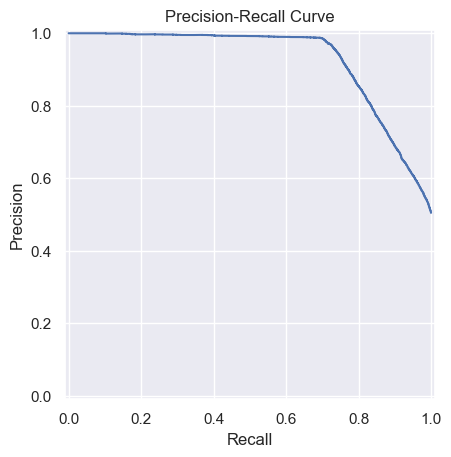

The Optimal Threshold is: 0.3347


In [18]:
threshold = threshold_precision_recall(XGB_GINI_Bayesian, X_train_GINI, y_train_GINI)

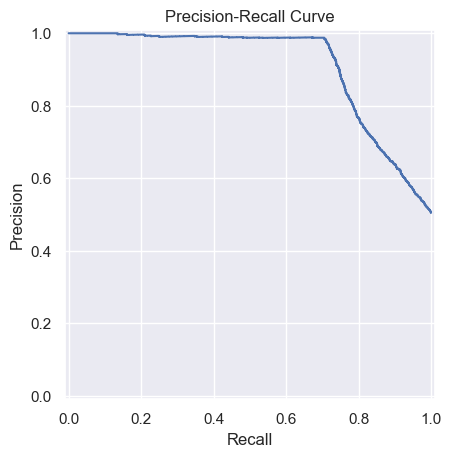

np.float32(0.42152026)

In [30]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

def threshold_precision_recall(Model, x_data, y_data):
    # generate predictions (probabilities)
    y_probs = Model.predict_proba(x_data)[:, 1]
    
    # compute precision and recall values
    precision, recall, thresholds = precision_recall_curve(y_data, y_probs)
    
    # plot the curve
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # calculate F1-scores (ignore last threshold to match array lengths)
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    
    # find the optimal threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # display msg
    print(f"The Optimal Threshold is: {optimal_threshold}")

    return optimal_threshold

In [13]:
def threshold_precision_recall(Model, x_data, y_data):
    """
    Determine the optimal classification threshold using the Precision-Recall curve.

    Args:
        model: Trained classifier with predict_proba() method
        x_data (array-like): Feature data
        y_data (array-like): True binary labels

    Returns:
        float: Optimal decision threshold that maximizes F1-score

    Notes:
        - Uses precision_recall_curve() from sklearn.metrics
        - Optimal threshold is where F1-score is maximized
        - Plots interactive Precision-Recall curve using matplotlib
    """
    # Generate probability predictions for positive class
    y_probs = Model.predict_proba(x_data)[:, 1]
    
    # Calculate precision-recall pairs and thresholds
    precision, recall, thresholds = precision_recall_curve(y_data, y_probs)

    # plot the curve
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Calculate F1 scores (exclude last precision/recall values)
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
    
    # Find optimal threshold with highest F1 score
    optimal_idx = np.nanargmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # display msg
    print(f"The Optimal Threshold is: {optimal_threshold:.4f}")

    return optimal_threshold

### XGBoost Classification (GINI)

In [5]:
# display model
print(XGB_GINI_Bayesian)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.999999999999999, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10633415208942865,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=1776, ...)


#### Train

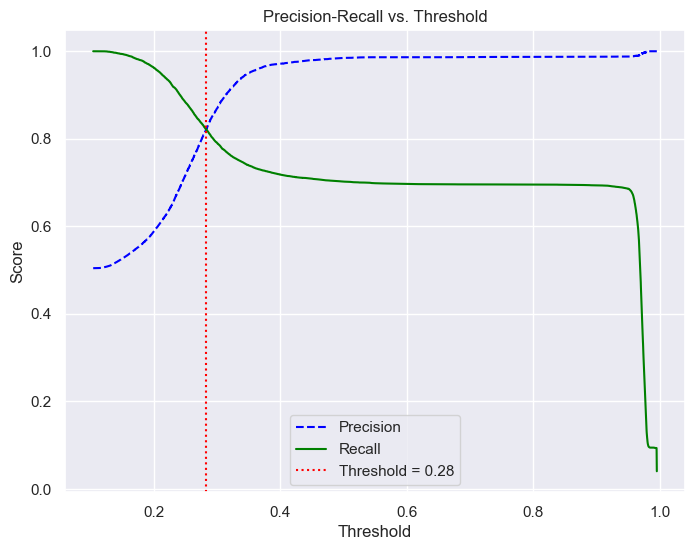

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.82      0.82     10732
        True       0.82      0.82      0.82     10923

    accuracy                           0.82     21655
   macro avg       0.82      0.82      0.82     21655
weighted avg       0.82      0.82      0.82     21655



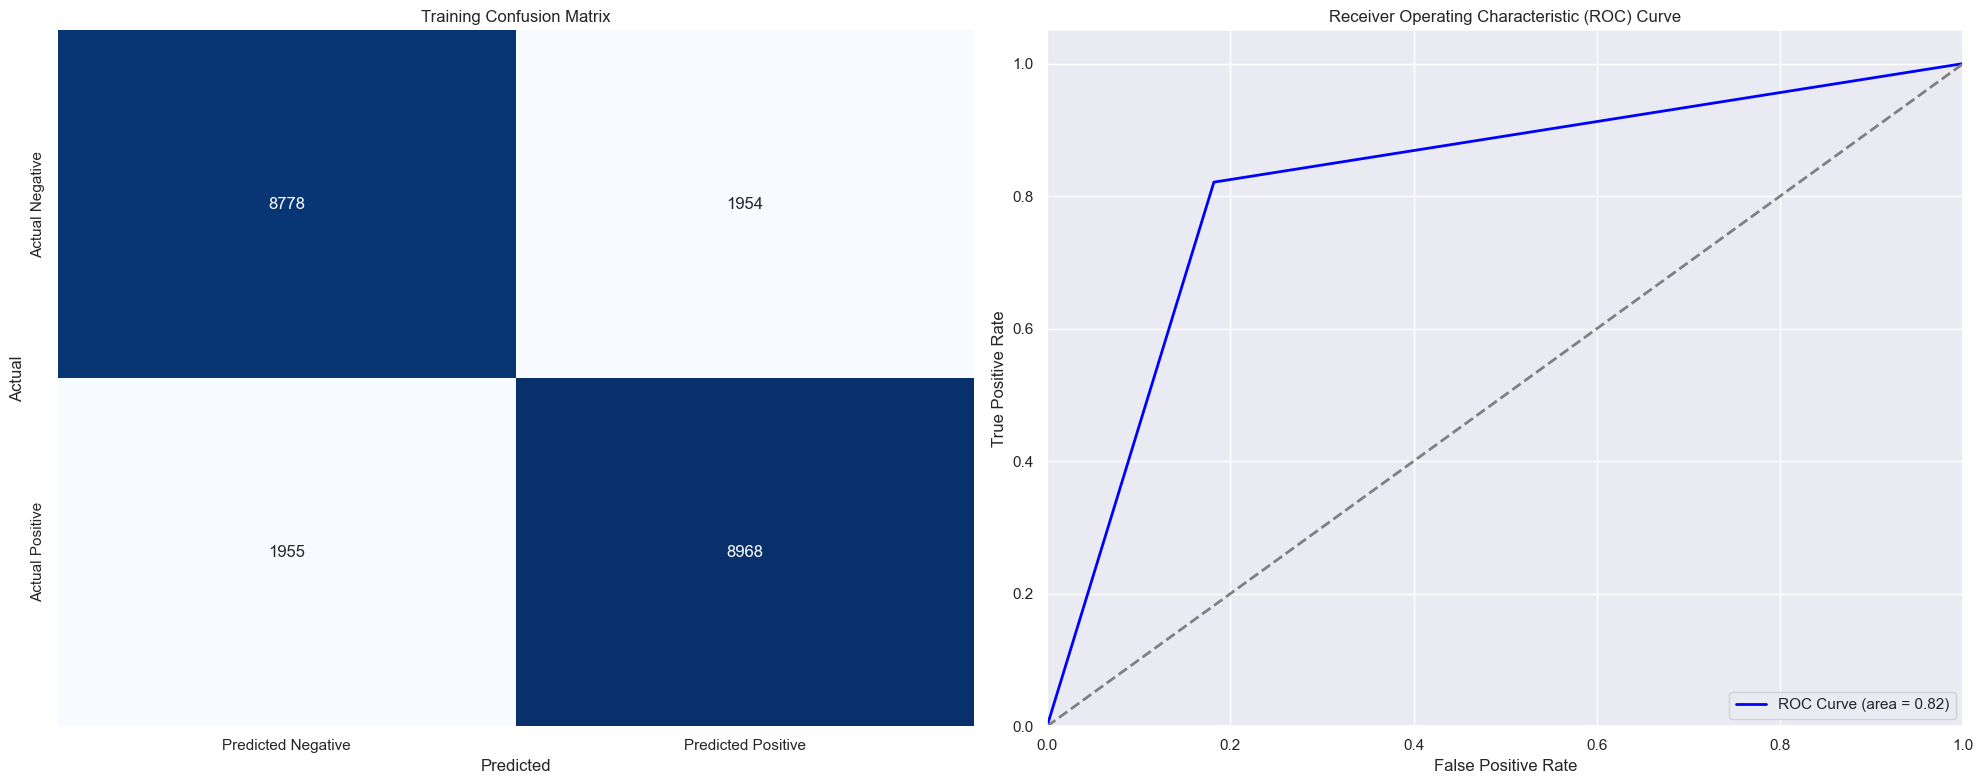

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.82102,0.821057,0.764415,0.821095,0.817928,0.819474


In [20]:
# initialize variables
algorithm = 'XGBoost Classification'
msg = f"2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed"
desc = f'{algorithm} - {msg}'
model = 'XGB_GINI_Bayesian'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, XGB_GINI_Bayesian, X_train_GINI, y_train_GINI, data_type, metric_df=None, train_threshold=True)
df_classfication

#### Test

In [21]:
distances = np.sqrt((1 - recall[:-1])**2 + (1 - precision[:-1])**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

NameError: name 'recall' is not defined

In [35]:
# Find threshold where recall ≥ 90%
target_recall = 0.9
optimal_idx = np.where(recall[:-1] >= target_recall)[0][0]
optimal_threshold = thresholds[optimal_idx]

In [37]:
# Find where precision ≈ recall
diff = np.abs(precision[:-1] - recall[:-1])
optimal_idx = np.argmin(diff)
optimal_threshold = thresholds[optimal_idx]

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.78      0.78      2683
        True       0.78      0.79      0.79      2731

    accuracy                           0.79      5414
   macro avg       0.79      0.79      0.79      5414
weighted avg       0.79      0.79      0.79      5414



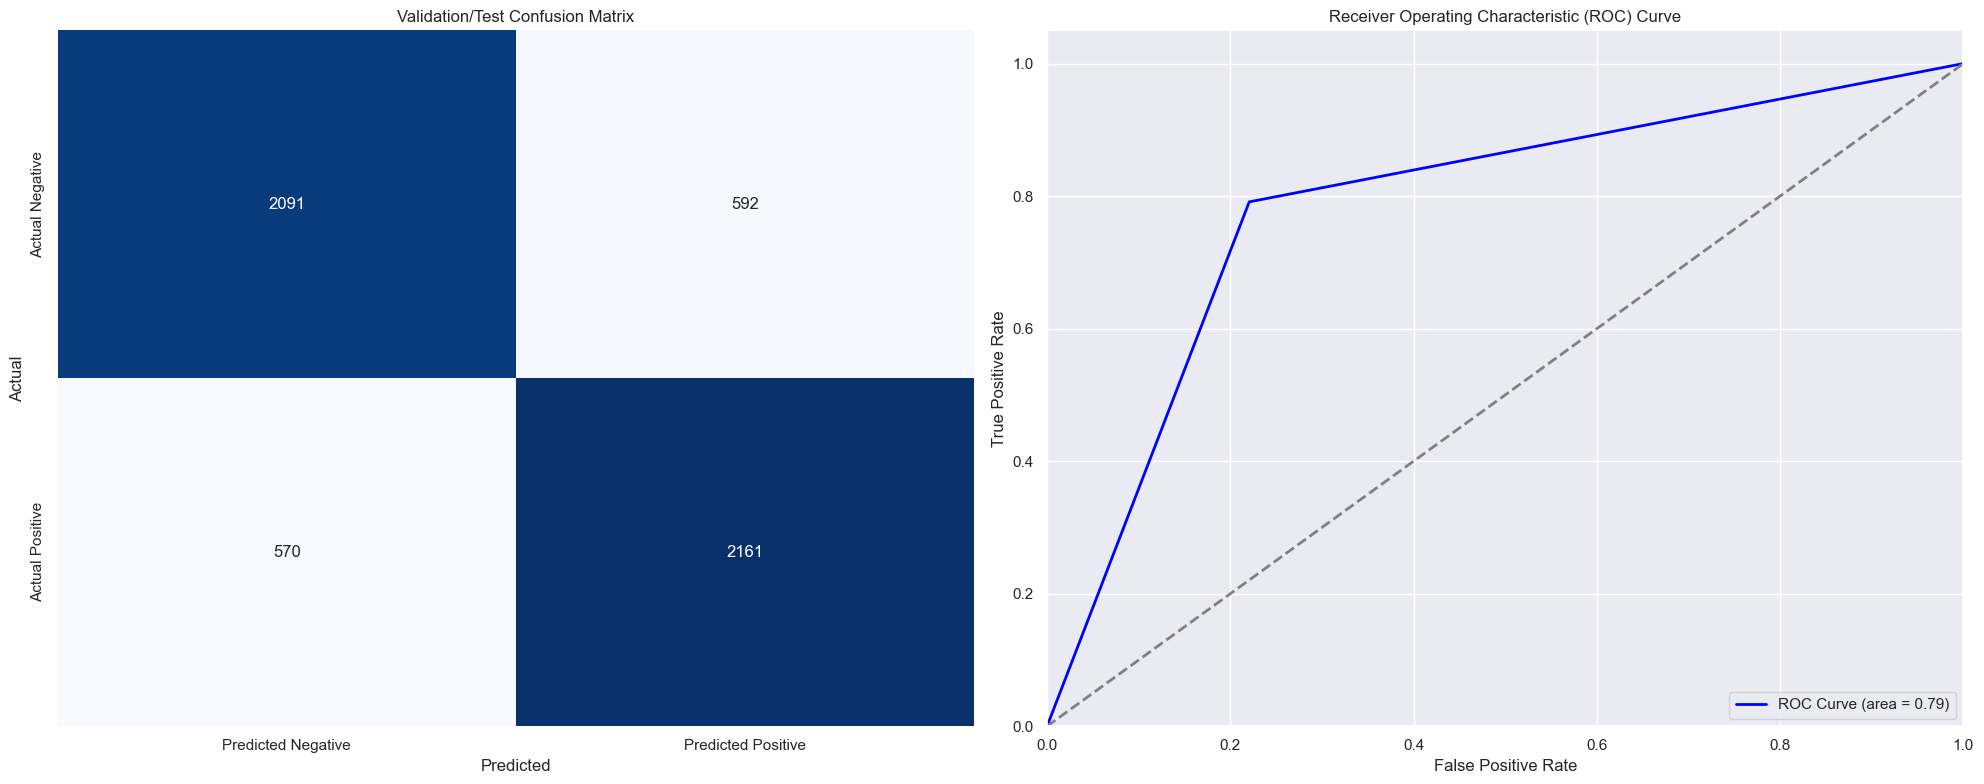

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.821020,0.821057,0.764415,0.821095,0.817928,0.819474
1,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Validation/test----,0.785371,0.791285,0.788111,0.726411,0.784962,0.779351,0.785318


In [22]:
# initialize variable
data_type = 'Validation/Test----'
# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, XGB_GINI_Bayesian, X_test_GINI, y_test_GINI, data_type, metric_df=df_classfication, train_threshold=threshold)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.93      0.85      2683
        True       0.91      0.74      0.82      2731

    accuracy                           0.83      5414
   macro avg       0.84      0.83      0.83      5414
weighted avg       0.85      0.83      0.83      5414



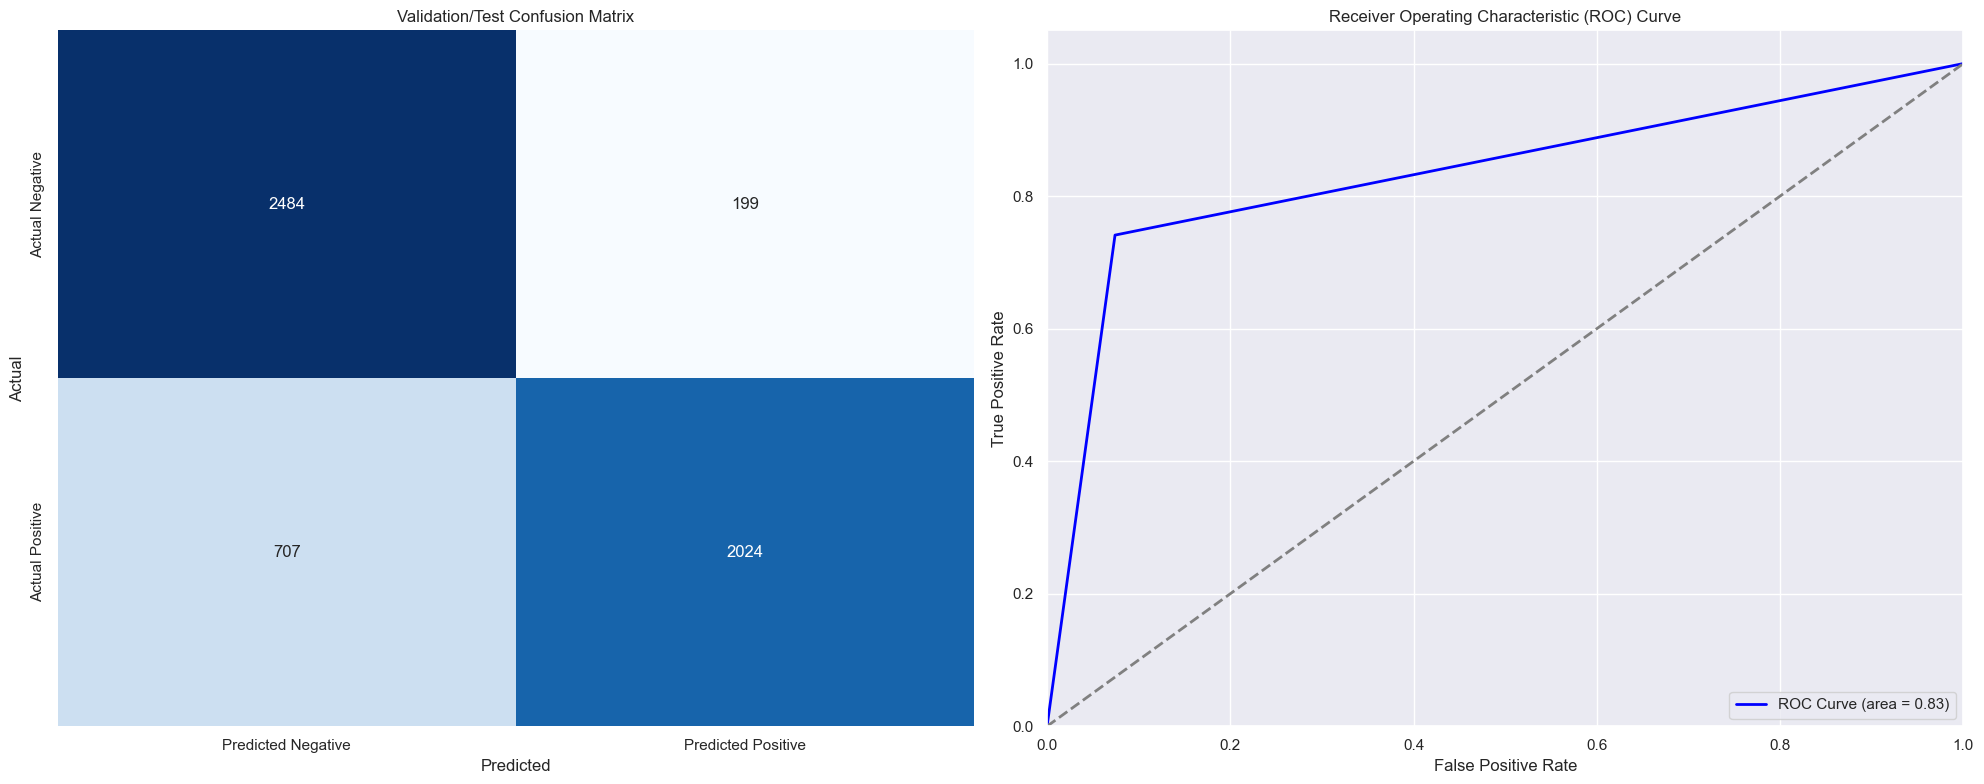

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.82102,0.821057,0.764415,0.821095,0.817928,0.819474
1,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.335,Validation/test----,0.832656,0.74112,0.817117,0.805364,0.910481,0.925829,0.833475


In [19]:
# initialize variable
data_type = 'Validation/Test----'
# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, XGB_GINI_Bayesian, X_test_GINI, y_test_GINI, data_type, metric_df=df_classfication, train_threshold=threshold)
df_classfication

### XGBoost Classification (SKBest)

#### Train

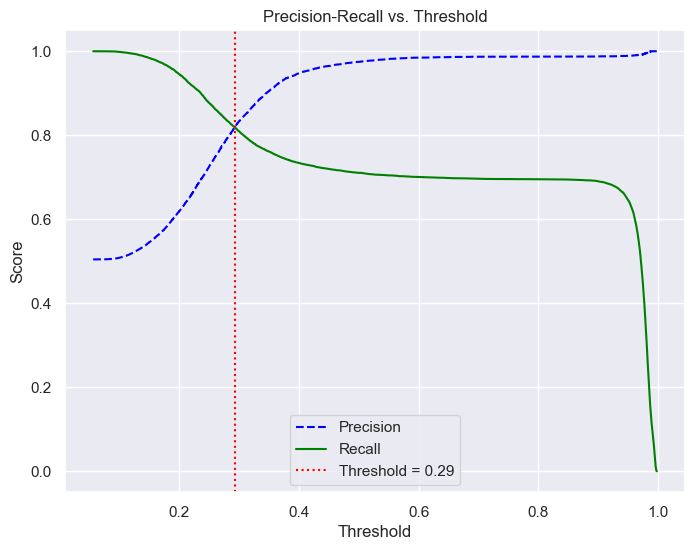

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.82      0.82     10732
        True       0.82      0.82      0.82     10923

    accuracy                           0.82     21655
   macro avg       0.82      0.82      0.82     21655
weighted avg       0.82      0.82      0.82     21655



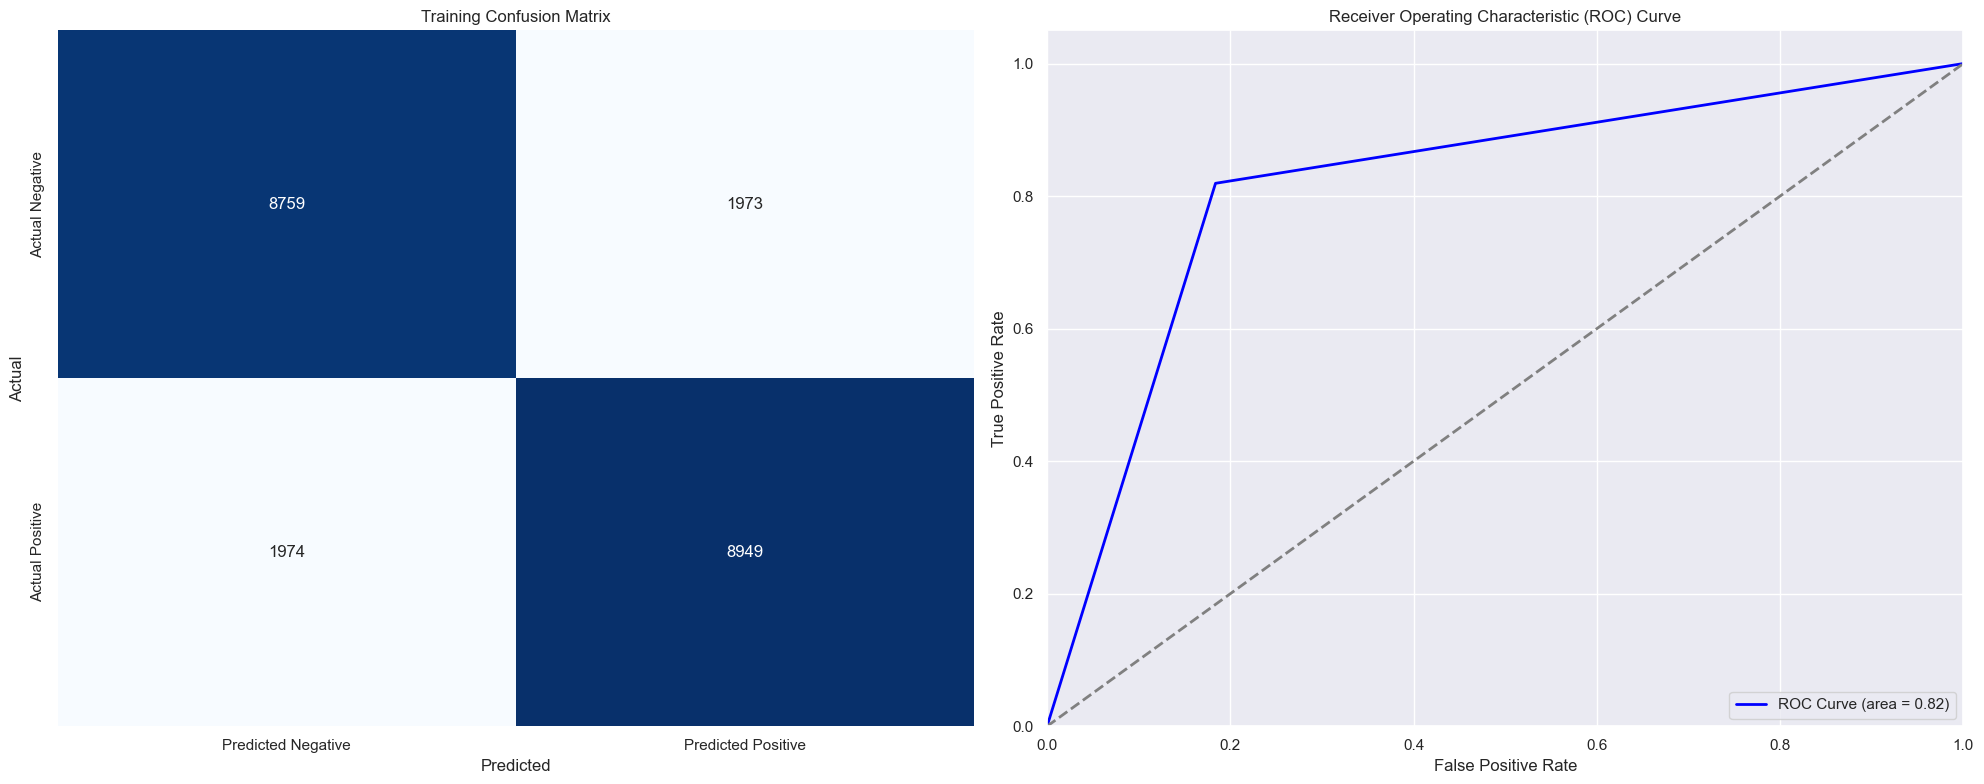

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.821020,0.821057,0.764415,0.821095,0.817928,0.819474
1,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Validation/test,0.785371,0.791285,0.788111,0.726411,0.784962,0.779351,0.785318
2,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed - Threshold: 0.293,Training,0.817733,0.819280,0.819318,0.762439,0.819355,0.816157,0.817719


In [8]:
# initialize variables
algorithm = 'XGBoost Classification'
msg = f"2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed"
desc = f'{algorithm} - {msg}'
model = 'XGB_SKBest_Bayesian'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, XGB_SKBest_Bayesian, X_train_SKBest, y_train_SKBest, data_type, metric_df=df_classfication, train_threshold=True)
df_classfication

#### Test

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.98      0.86      2683
        True       0.97      0.71      0.82      2731

    accuracy                           0.85      5414
   macro avg       0.87      0.85      0.84      5414
weighted avg       0.87      0.85      0.84      5414



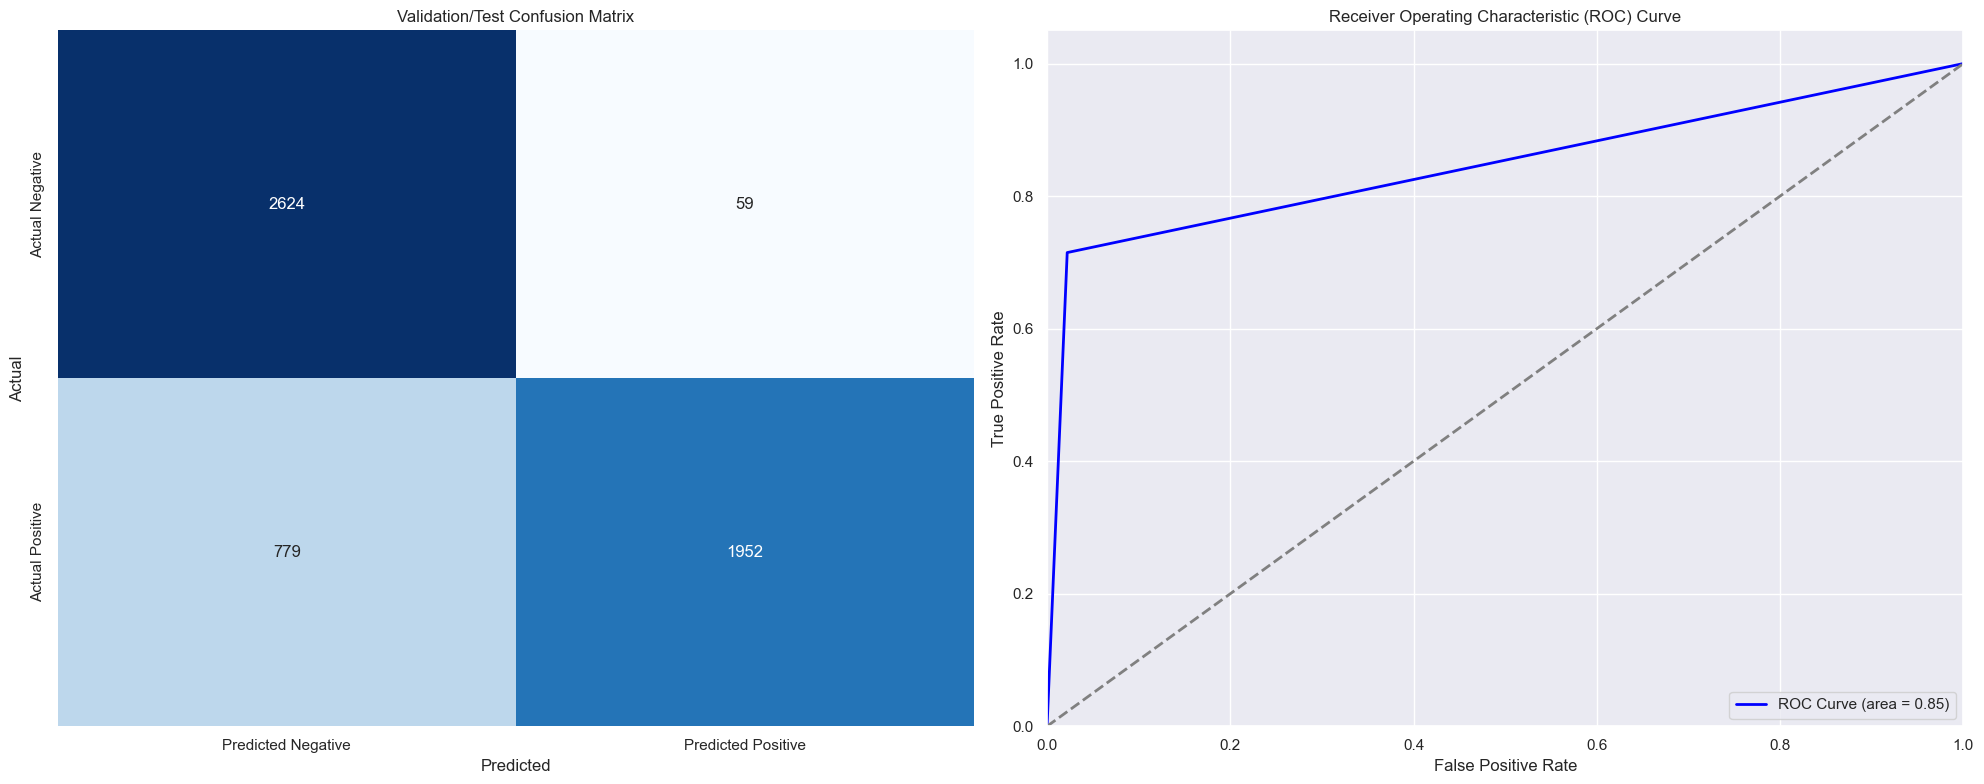

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.821020,0.821057,0.764415,0.821095,0.817928,0.819474
1,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Validation/test,0.785371,0.791285,0.788111,0.726411,0.784962,0.779351,0.785318
2,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed - Threshold: 0.293,Training,0.817733,0.819280,0.819318,0.762439,0.819355,0.816157,0.817719
3,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed,Validation/test,0.845216,0.714756,0.823281,0.837673,0.970661,0.978010,0.846383


In [9]:
# initialize variable
data_type = 'Validation/Test'
# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, XGB_SKBest_Bayesian, X_test_SKBest, y_test_SKBest, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.78      0.79      2683
        True       0.79      0.79      0.79      2731

    accuracy                           0.79      5414
   macro avg       0.79      0.79      0.79      5414
weighted avg       0.79      0.79      0.79      5414



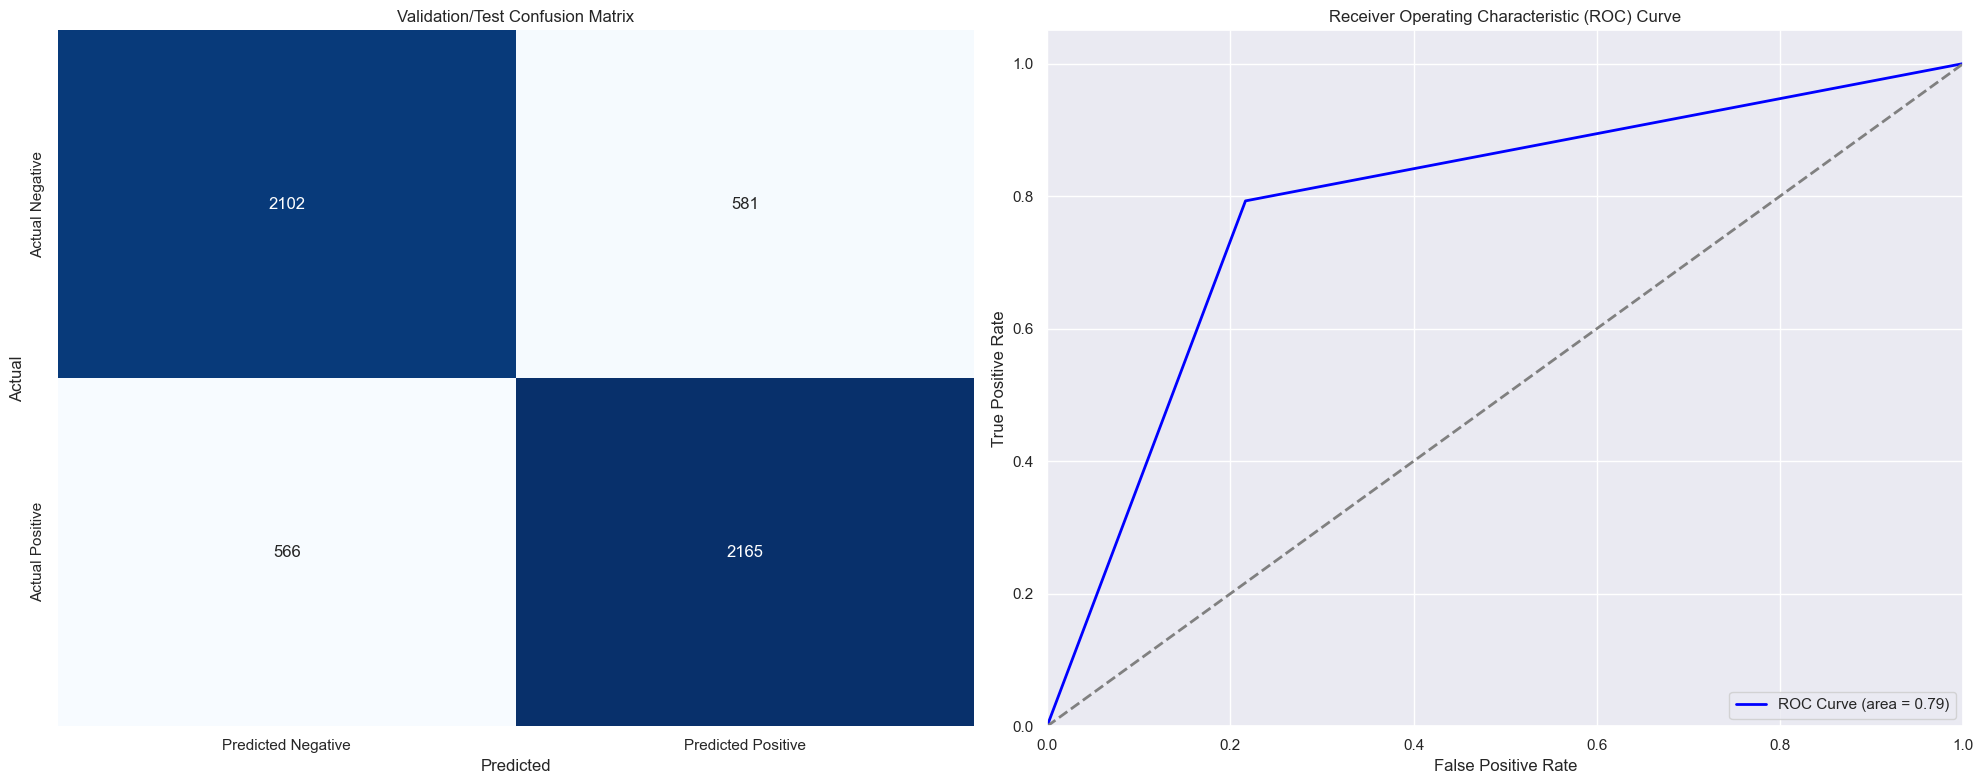

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Training,0.819487,0.821020,0.821057,0.764415,0.821095,0.817928,0.819474
1,XGBoost Classification,XGB_GINI_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search with Custom Score Function (youdens_j_score) - Features where Max Gini Impurity < 5% removed - Threshold: 0.283,Validation/test,0.785371,0.791285,0.788111,0.726411,0.784962,0.779351,0.785318
2,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed - Threshold: 0.293,Training,0.817733,0.819280,0.819318,0.762439,0.819355,0.816157,0.817719
3,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed,Validation/test,0.845216,0.714756,0.823281,0.837673,0.970661,0.978010,0.846383
4,XGBoost Classification,XGB_SKBest_Bayesian,XGBoost Classification - 2011-2016: Discretization - Bayesian Search: Scoring F1 - Select K-Best p_value < 0.05 p_value removed - Threshold: 0.293,Validation/test,0.788142,0.792750,0.790579,0.729563,0.788420,0.783451,0.788101


In [10]:
# initialize variable
data_type = 'Validation/Test'
# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, XGB_SKBest_Bayesian, X_test_SKBest, y_test_SKBest, data_type, metric_df=df_classfication, train_threshold=threshold)
df_classfication